# 8.4. Redes multi-ramificações (GoogLeNet)
8.4. Multi-Branch Networks (GoogLeNet)


Em 2014, o GoogLeNet venceu o ImageNet Challenge (Szegedy et al. , 2015), usando uma estrutura que combinava os pontos fortes do NiN (Lin et al. , 2013), blocos repetidos (Simonyan e Zisserman, 2014  e um coquetel de kernels de convolução. Foi sem dúvida também a primeira rede que exibiu uma distinção clara entre o __tronco (ingestão de dados), corpo (processamento de dados) e cabeça (previsão) em uma CNN__. 

Esse padrão de design persistiu desde então no design de redes profundas: 

- o tronco é dado pelas duas ou três primeiras convoluções que operam na imagem. Elas extraem recursos de baixo nível das imagens subjacentes.
- Isso é seguido por um corpo de blocos convolucionais.
- Finalmente, a cabeça mapeia os recursos obtidos até agora para o problema de classificação, segmentação, detecção ou rastreamento necessário em questão.

A principal contribuição no GoogLeNet foi o design do corpo da rede. Ele resolveu o problema de selecionar kernels de convolução de uma forma engenhosa. Enquanto outros trabalhos tentaram identificar qual convolução, variando de 1x1 para 11x11 seria melhor, ele simplesmente concatenava convoluções multi-ramificação. A seguir, apresentamos uma versão ligeiramente simplificada do GoogLeNet: o design original incluía uma série de truques para estabilizar o treinamento por meio de funções de perda intermediárias, aplicadas a várias camadas da rede. Eles não são mais necessários devido à disponibilidade de algoritmos de treinamento aprimorados.

In [11]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 8.4.1. Blocos de Iniciação

O bloco convolucional básico no GoogLeNet é chamado de bloco Inception , derivado do meme “precisamos ir mais fundo” do filme Inception .

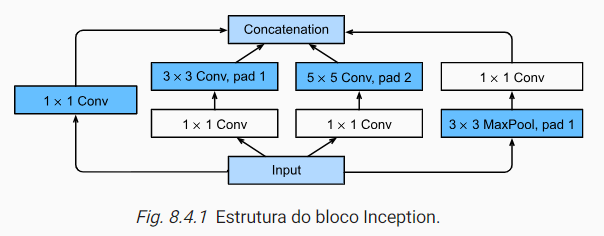

Todos os quatro ramos usam preenchimento apropriado para dar à entrada e à saída a mesma altura e largura. Finalmente, as saídas ao longo de cada ramo são concatenadas ao longo da dimensão do canal e compreendem a saída do bloco. Os hiperparâmetros comumente ajustados do bloco Inception são o número de canais de saída por camada, ou seja, como alocar capacidade entre convoluções de tamanhos diferentes.

In [12]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1 (Ramo 1)
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))                        # ramo b1: relu de b1_1      
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))     # ramo b2: relu para o b2_2 alimentado pelo b2_1
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))     # ramo b3: relu para o b3_2 alimentado pelo b3_1
        b4 = F.relu(self.b4_2(self.b4_1(x)))             # ramo b4: relu para o b4_2 alimentado pelo b4_1
        return torch.cat((b1, b2, b3, b4), dim=1)        # concatenação de todos os ramos

Para obter alguma intuição sobre o porquê de essa rede funcionar tão bem, considere a combinação dos filtros. Eles exploram a imagem em uma variedade de tamanhos de filtro. Isso significa que detalhes em diferentes extensões podem ser reconhecidos eficientemente por filtros de tamanhos diferentes. Ao mesmo tempo, podemos alocar diferentes quantidades de parâmetros para diferentes filtros.

# 8.4.2. Modelo GoogLeNet

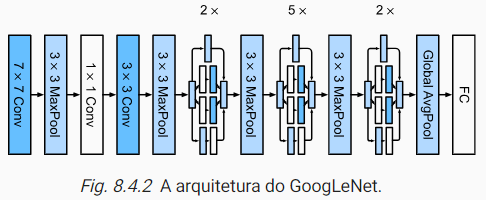



Agora podemos implementar o GoogLeNet pedaço por pedaço. Vamos começar com o stem. O primeiro módulo usa um 64-channel 7x7
camada convolucional.

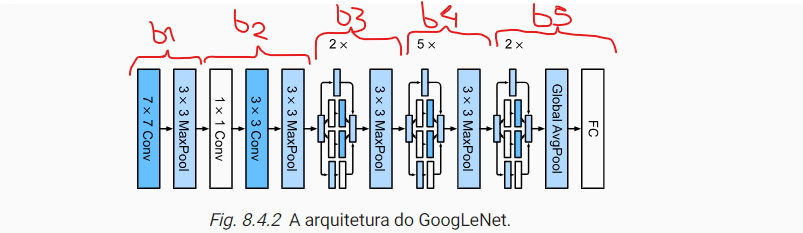

In [13]:
class GoogleNet(d2l.Classifier):
    def b1(self):                  # não confundir ramo (branch) b1 com bloco (block) b1. Este é o bloco b1.              
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

O segundo módulo usa duas camadas convolucionais: primeiro, uma camada de 64 canais 1x1 camada convolucional, seguida por uma 3x3
 camada convolucional que triplica o número de canais. Isso corresponde ao segundo ramo no bloco Inception e conclui o design do corpo. Neste ponto, temos 192 canais.

In [14]:
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

O terceiro módulo conecta dois blocos Inception completos em série. O número de canais de saída do primeiro bloco Inception é 
64+128+32+32=256.

In [15]:
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

O quarto módulo é mais complicado. Ele conecta cinco blocos Inception em série.

In [16]:
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

- O quinto módulo tem dois blocos de iniciação .
- Deve-se notar que o quinto bloco é seguido pela camada de saída. Este bloco usa a camada de pooling média global para alterar a altura e a largura de cada canal para 1, assim como em NiN.
- Finalmente, transformamos a saída em uma matriz bidimensional seguida por uma camada totalmente conectada cujo número de saídas é o número de classes de rótulo.

In [17]:
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

Agora que definimos todos os blocos, é só montá-los em uma rede completa.

In [18]:
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

O modelo GoogLeNet é computacionalmente complexo. Observe o grande número de hiperparâmetros relativamente arbitrários em termos do número de canais escolhidos, o número de blocos antes da redução da dimensionalidade, a partição relativa da capacidade entre os canais, etc. Muito disso se deve ao fato de que, na época em que o GoogLeNet foi introduzido, ferramentas automáticas para definição de rede ou exploração de design ainda não estavam disponíveis. Por exemplo, agora damos por certo que uma estrutura de aprendizado profundo competente é capaz de inferir dimensionalidades de tensores de entrada automaticamente. Na época, muitas dessas configurações tinham que ser especificadas explicitamente pelo experimentador, muitas vezes retardando a experimentação ativa. Além disso, as ferramentas necessárias para a exploração automática ainda estavam em fluxo e os experimentos iniciais em grande parte equivaliam a exploração de força bruta dispendiosa, algoritmos genéticos e estratégias semelhantes.

Por enquanto, a única modificação que faremos é reduzir a altura e a largura da entrada de 224 para 96 ​​para ter um tempo de treinamento razoável no Fashion-MNIST. Isso simplifica o cálculo. Vamos dar uma olhada nas mudanças no formato da saída entre os vários módulos.

In [19]:
model = GoogleNet().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


# 8.4.3. Treinamento

Como antes, treinamos nosso modelo usando o conjunto de dados Fashion-MNIST.

In [ ]:
model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [21]:
# SUMÁRIO DETALHADO: size(96,96)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = GoogleNet(lr=0.01)
X = torch.randn(1, 1, 96, 96)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (1, 96, 96))
params


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           3,200
              ReLU-2           [-1, 64, 48, 48]               0
         MaxPool2d-3           [-1, 64, 24, 24]               0
            Conv2d-4           [-1, 64, 24, 24]           4,160
              ReLU-5           [-1, 64, 24, 24]               0
            Conv2d-6          [-1, 192, 24, 24]         110,784
              ReLU-7          [-1, 192, 24, 24]               0
         MaxPool2d-8          [-1, 192, 12, 12]               0
            Conv2d-9           [-1, 64, 12, 12]          12,352
           Conv2d-10           [-1, 96, 12, 12]          18,528
           Conv2d-11          [-1, 128, 12, 12]         110,720
           Conv2d-12           [-1, 16, 12, 12]           3,088
           Conv2d-13           [-1, 32, 12, 12]          12,832
        MaxPool2d-14          [-1, 192,

{'conv': 118144, 'lr': 10250}

# 8.4.4. Discussão

Uma característica fundamental do GoogLeNet é que ele é, na verdade, mais barato de computar do que seus predecessores, ao mesmo tempo em que fornece precisão aprimorada. Isso marca o início de um design de rede muito mais deliberado que compensa o custo de avaliar uma rede com uma redução de erros. Também marca o início da experimentação em nível de bloco com hiperparâmetros de design de rede, embora fosse totalmente manual na época.

Nas seções seguintes, encontraremos uma série de escolhas de design (por exemplo, normalização de lote, conexões residuais e agrupamento de canais) que nos permitem melhorar as redes significativamente. Por enquanto, você pode se orgulhar de ter implementado o que é, sem dúvida, a primeira CNN verdadeiramente moderna.

# Código Agrupado



In [ ]:
# -----------------------------------------------------------------------------------------------------
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
# -----------------------------------------------------------------------------------------------------


# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1 (Ramo 1)
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))                        # ramo b1: relu de b1_1      
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))     # ramo b2: relu para o b2_2 alimentado pelo b2_1
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))     # ramo b3: relu para o b3_2 alimentado pelo b3_1
        b4 = F.relu(self.b4_2(self.b4_1(x)))             # ramo b4: relu para o b4_2 alimentado pelo b4_1
        return torch.cat((b1, b2, b3, b4), dim=1)        # concatenação de todos os ramos
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
class GoogleNet(d2l.Classifier):
    def b1(self):                  # não confundir ramo (branch) b1 com bloco (block) b1. Este é o bloco b1.              
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# -----------------------------------------------------------------------------------------------------

        
# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# -----------------------------------------------------------------------------------------------------

    
# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# -----------------------------------------------------------------------------------------------------

    
# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# -----------------------------------------------------------------------------------------------------

    
# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
model = GoogleNet().layer_summary((1, 1, 96, 96))
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)
# -----------------------------------------------------------------------------------------------------

# # -----------------------------------------------------------------------------------------------------
# from google.colab import drive
# drive.mount('/content/drive')
# # -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
# SALVA PARÂMETROS TREINADOS
# torch.save(model.state_dict(), '/content/drive/My Drive/GoogleNet.params')                    # salva todos os parâmetros do modelo treinado.
torch.save(model.state_dict(), 'GoogleNet.params')                    # salva todos os parâmetros do modelo treinado.
#  EXTENSÃO PARA PARÂMETROS: .params

[(name, param.shape) for name, param in model.named_parameters()]   # nomes dos parâmetros
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
# LOAD PARAMS:
# Recuperar/carregar os parâmetros salvos.
clone = model                                  # instanciamos um clone do modelo MLP original. É possível usar clone ou model.
# clone.load_state_dict(torch.load('/content/drive/My Drive/GoogleNet.params'))  # lemos os parâmetros armazenados no arquivo diretamente.
clone.load_state_dict(torch.load('GoogleNet.params'))  # lemos os parâmetros armazenados no arquivo diretamente.
clone.eval()
 #  EXTENSÃO PARA PARÂMETROS: .params
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
# SUMÁRIO DETALHADO: size(96,96)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = GoogleNet(lr=0.01)
X = torch.randn(1, 1, 96, 96)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (1, 96, 96))
params
# -----------------------------------------------------------------------------------------------------



# 8.4.5. Exercícios

# Ex. 2 - Qual é o tamanho mínimo de imagem necessário para que o GoogLeNet funcione?

Como o GoogLeNet reduz a imagem pela metade 5 vezes, o tamanho de imagem mínimo é 2^5=32.

In [26]:
# -----------------------------------------------------------------------------------------------------
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


# -----------------------------------------------------------------------------------------------------


# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)


# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1 (Ramo 1)
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))  # ramo b1: relu de b1_1
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))  # ramo b2: relu para o b2_2 alimentado pelo b2_1
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))  # ramo b3: relu para o b3_2 alimentado pelo b3_1
        b4 = F.relu(self.b4_2(self.b4_1(x)))  # ramo b4: relu para o b4_2 alimentado pelo b4_1
        return torch.cat((b1, b2, b3, b4), dim=1)  # concatenação de todos os ramos


# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
class GoogleNet(d2l.Classifier):
    def b1(self):  # não confundir ramo (branch) b1 com bloco (block) b1. Este é o bloco b1.
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())


# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)


# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
model = GoogleNet().layer_summary((1, 1, 32, 32))
# -----------------------------------------------------------------------------------------------------


Sequential output shape:	 torch.Size([1, 64, 8, 8])
Sequential output shape:	 torch.Size([1, 192, 4, 4])
Sequential output shape:	 torch.Size([1, 480, 2, 2])
Sequential output shape:	 torch.Size([1, 832, 1, 1])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


# Ex. 3 - Você pode projetar uma variante do GoogLeNet que funcione na resolução nativa do Fashion-MNIST? 28x28 pixels? Como você precisaria mudar o stem, o body e o head da rede, se é que precisaria mudar alguma coisa?

In [28]:
# -----------------------------------------------------------------------------------------------------
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


# -----------------------------------------------------------------------------------------------------


# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)


# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1 (Ramo 1)
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))  # ramo b1: relu de b1_1
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))  # ramo b2: relu para o b2_2 alimentado pelo b2_1
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))  # ramo b3: relu para o b3_2 alimentado pelo b3_1
        b4 = F.relu(self.b4_2(self.b4_1(x)))  # ramo b4: relu para o b4_2 alimentado pelo b4_1
        return torch.cat((b1, b2, b3, b4), dim=1)  # concatenação de todos os ramos


# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
class GoogleNet(d2l.Classifier):
    def b1(self):  # não confundir ramo (branch) b1 com bloco (block) b1. Este é o bloco b1.
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        # return nn.Sequential(nn.LazyConv2d(64, kernel_size=5, stride=1, padding=2),
        #              nn.ReLU(),
        #              # nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        #                 )
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())


# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)


# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
model = GoogleNet().layer_summary((1, 1, 28, 28))
# -----------------------------------------------------------------------------------------------------


Sequential output shape:	 torch.Size([1, 64, 7, 7])
Sequential output shape:	 torch.Size([1, 192, 4, 4])
Sequential output shape:	 torch.Size([1, 480, 2, 2])
Sequential output shape:	 torch.Size([1, 832, 1, 1])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
# Funciona corretamente!!!
# Entretanto, caso deseje, é possível alterar o bloco b1, modificando o stride e o padding

class GoogleNet(d2l.Classifier):
    def b1(self):  # não confundir ramo (branch) b1 com bloco (block) b1. Este é o bloco b1.
        # return nn.Sequential(
        #     nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
        #     nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        return nn.Sequential(nn.LazyConv2d(64, kernel_size=5, stride=1, padding=2),
                     nn.ReLU(),
                     # nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                        )

# Ex. 4 - Compare os tamanhos dos parâmetros do modelo de AlexNet, VGG, NiN e GoogLeNet. Como as duas últimas arquiteturas de rede reduzem significativamente o tamanho dos parâmetros do modelo?

# AlexNet:

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt            # para plot
from torchvision.transforms import v2      # para resize
# ------------------------------------------------------------------------------------


class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)


AlexNet().layer_summary((1, 1, 224, 224))


model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224)) # Resize de 28x28 para 224x224, para adquar a imagem a rede
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
# trainer.fit(model, data)


# -----------------------------------------------------------------------------------------------------
# SUMÁRIO DETALHADO: size(1,1,224, 224)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = AlexNet(lr=0.01)

X = torch.randn(1,1,224, 224)
# X = torch.randn(1,3,224, 224)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (1, 224, 224))
# summary(model, (3, 224, 224))
params


C:\Users\zeh\pythonProject\.venv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

{'conv': 0, 'lr': 43040778}

# VGG:

In [30]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------

def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):    # Diversos Conv/ReLU seguido por MaxPool2d
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)


# arch consiste em uma lista de tuplas (uma por bloco), onde cada uma contém dois valores:
#o número de camadas convolucionais e o número de canais de saída, que são precisamente os argumentos necessários para chamar a vgg_block função.

model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
# trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer = d2l.Trainer(max_epochs=10)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)    # aplica a função init_cnn, que realiza a inicialização Xavier
# trainer.fit(model, data)


# -----------------------------------------------------------------------------------------------------
# SUMÁRIO DETALHADO: size(224,224)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


# arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128))
# model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)


vgg = VGG(arch=arch)
X = torch.randn(1,1, 224, 224)
_ = vgg(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(vgg.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg = vgg.to(device)

summary(vgg, (1, 224, 224))
params

# -----------------------------------------------------------------------------------------------------


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             160
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,928
             ReLU-10           [-1, 64, 56, 56]               0
        MaxPool2d-11           [-1, 64, 28, 28]               0
           Conv2d-12          [-1, 128, 28, 28]          73,856
             ReLU-13          [-1, 128, 28, 28]               0
           Conv2d-14          [-1, 128,

{'conv': 576832, 'lr': 42516490}

# NiN:

In [32]:
import torch
from torch import nn
from d2l import torch as d2l

# -----------------------------------------------------------------------------------------------------
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

# -----------------------------------------------------------------------------------------------------
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),    # Saída: [(224-11+2*0//4)+1] = 54
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)                                # aplica a inicialização Xavier 

# -----------------------------------------------------------------------------------------------------
NiN().layer_summary((1, 1, 224, 224))

# -----------------------------------------------------------------------------------------------------
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
# trainer.fit(model, data)

# -----------------------------------------------------------------------------------------------------
# SUMÁRIO DETALHADO: size(224,224)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = NiN(lr=0.05)
X = torch.randn(1,1, 224, 224)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (1, 224, 224))
params
# -----------------------------------------------------------------------------------------------------


Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          11,712
              ReLU-2           [-1, 96, 54, 54]               0
            Conv2d-3           [-1, 96, 54, 54]           9,312
              ReLU-4           [-1, 96, 54, 54]               0
            Conv2d-5           [-1, 96, 54, 54]           9,312
              ReLU-6    

{'conv': 1992166, 'lr': 0}

# GoogLeNet:

In [2]:
# -----------------------------------------------------------------------------------------------------
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
# -----------------------------------------------------------------------------------------------------


# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1 (Ramo 1)
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))                        # ramo b1: relu de b1_1      
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))     # ramo b2: relu para o b2_2 alimentado pelo b2_1
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))     # ramo b3: relu para o b3_2 alimentado pelo b3_1
        b4 = F.relu(self.b4_2(self.b4_1(x)))             # ramo b4: relu para o b4_2 alimentado pelo b4_1
        return torch.cat((b1, b2, b3, b4), dim=1)        # concatenação de todos os ramos
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
class GoogleNet(d2l.Classifier):
    def b1(self):                  # não confundir ramo (branch) b1 com bloco (block) b1. Este é o bloco b1.              
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# -----------------------------------------------------------------------------------------------------

        
# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# -----------------------------------------------------------------------------------------------------

    
# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# -----------------------------------------------------------------------------------------------------

    
# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# -----------------------------------------------------------------------------------------------------

    
# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
model = GoogleNet().layer_summary((1, 1, 96, 96))
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
# trainer.fit(model, data)
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
# SUMÁRIO DETALHADO: size(96,96)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = GoogleNet(lr=0.01)
X = torch.randn(1,1, 224, 224)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (1, 224, 224))
params
# -----------------------------------------------------------------------------------------------------



Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,200
              ReLU-2         [-1, 64, 112, 112]               0
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]           4,160
              ReLU-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 192, 56, 56]         110,784
              ReLU-7          [-1, 192, 56, 56]               0
         MaxPool2d-8          [-1, 192, 28, 28]               0
            Conv2d-9           [-1, 64, 28, 28]       

{'conv': 118144, 'lr': 10250}

X = torch.randn(1,1, 224, 224) \
summary(model, (1, 224, 224))

- __AlexNet__: Total params: 46,764,746; Params size (MB): 178.39
- __VGG__: Total params: 43,093,322; Params size (MB): 164.39
- __NiN__: Total params: 1,992,166; Params size (MB): 7.60
- __GoogLeNet__: Total params: 5,977,530; Params size (MB): 22.80


# Ex. 5 - Compare a quantidade de computação necessária no GoogLeNet e no AlexNet. Como isso afeta o design de um chip acelerador, por exemplo, em termos de tamanho de memória, largura de banda de memória, tamanho de cache, quantidade de computação e o benefício de operações especializadas?

# GoogleNet
resize=(96, 96)

In [3]:
# -----------------------------------------------------------------------------------------------------
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
# -----------------------------------------------------------------------------------------------------


# # ------------------------------------------------------------------------------------
# # ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# # FAZER num_workers=0 NA CLASSE FashionMNIST.

# # return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
# #                                    num_workers=0)

# # ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
# @d2l.add_to_class(d2l.FashionMNIST)
# def get_dataloader(self, train):
#     """Defined in :numref:`sec_fashion_mnist`"""
#     data = self.train if train else self.val
#     return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                        num_workers=0)
# # -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1 (Ramo 1)
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))                        # ramo b1: relu de b1_1      
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))     # ramo b2: relu para o b2_2 alimentado pelo b2_1
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))     # ramo b3: relu para o b3_2 alimentado pelo b3_1
        b4 = F.relu(self.b4_2(self.b4_1(x)))             # ramo b4: relu para o b4_2 alimentado pelo b4_1
        return torch.cat((b1, b2, b3, b4), dim=1)        # concatenação de todos os ramos
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
class GoogleNet(d2l.Classifier):
    def b1(self):                  # não confundir ramo (branch) b1 com bloco (block) b1. Este é o bloco b1.              
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# -----------------------------------------------------------------------------------------------------

        
# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# -----------------------------------------------------------------------------------------------------

    
# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# -----------------------------------------------------------------------------------------------------

    
# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# -----------------------------------------------------------------------------------------------------

    
# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
model = GoogleNet().layer_summary((1, 1, 96, 96))
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
# trainer.fit(model, data)
# -----------------------------------------------------------------------------------------------------

# # -----------------------------------------------------------------------------------------------------
# from google.colab import drive
# drive.mount('/content/drive')
# # -----------------------------------------------------------------------------------------------------


# # -----------------------------------------------------------------------------------------------------
# # SALVA PARÂMETROS TREINADOS
# # torch.save(model.state_dict(), '/content/drive/My Drive/GoogleNet.params')                    # salva todos os parâmetros do modelo treinado.
# torch.save(model.state_dict(), 'GoogleNet.params')                    # salva todos os parâmetros do modelo treinado.
# #  EXTENSÃO PARA PARÂMETROS: .params

# [(name, param.shape) for name, param in model.named_parameters()]   # nomes dos parâmetros
# # -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
# LOAD PARAMS:
# Recuperar/carregar os parâmetros salvos.
clone = model                                  # instanciamos um clone do modelo MLP original. É possível usar clone ou model.
# clone.load_state_dict(torch.load('/content/drive/My Drive/GoogleNet.params'))  # lemos os parâmetros armazenados no arquivo diretamente.
clone.load_state_dict(torch.load('GoogleNet.params'))  # lemos os parâmetros armazenados no arquivo diretamente.
clone.eval()
 #  EXTENSÃO PARA PARÂMETROS: .params
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
# SUMÁRIO DETALHADO: size(96,96)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = GoogleNet(lr=0.01)
X = torch.randn(1, 1, 96, 96)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (1, 96, 96))
params
# -----------------------------------------------------------------------------------------------------



Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           3,200
              ReLU-2           [-1, 64, 48, 48]               0
         MaxPool2d-3           [-1, 64, 24, 24]               0
            Conv2d-4           [-1, 64, 24, 24]           4,160
              ReLU-5           [-1, 64, 24, 24]               0
            Conv2d-6          [-1, 192, 24, 24]         110,784
              ReLU-7          [-1, 192, 24, 24]               0
         MaxPool2d-8          [-1, 192, 12, 12]               0
            Conv2d-9           [-1, 64, 12, 12]       

{'conv': 118144, 'lr': 10250}

In [4]:
from thop import profile

# model = NiN(lr=0.05)
model = clone                       # clone já possui os parâmetros treinados
X = torch.randn(1,1, 96, 96)

flops, params = profile(model, inputs=(X,))

print("Total FLOPs:", flops)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Total FLOPs: 276076544.0


-----------------------------

# AlexNet
resize=(224, 224)

In [13]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt            # para plot
from torchvision.transforms import v2      # para resize
# # ------------------------------------------------------------------------------------
# # ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# # FAZER num_workers=0 NA CLASSE FashionMNIST.

# # return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
# #                                    num_workers=0)

# # ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
# @d2l.add_to_class(d2l.FashionMNIST)
# def get_dataloader(self, train):
#     """Defined in :numref:`sec_fashion_mnist`"""
#     data = self.train if train else self.val
#     return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                        num_workers=0)

# # ------------------------------------------------------------------------------------
# # ------------------------------------------------------------------------------------

class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)


AlexNet().layer_summary((1, 1, 224, 224))


model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224)) # Resize de 28x28 para 224x224, para adquar a imagem a rede
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
# trainer.fit(model, data)



# # -----------------------------------------------------------------------------------------------------
# from google.colab import drive
# drive.mount('/content/drive')
# # -----------------------------------------------------------------------------------------------------


# # -----------------------------------------------------------------------------------------------------
# # SALVA PARÂMETROS TREINADOS
# # torch.save(model.state_dict(), '/content/drive/My Drive/GoogleNet.params')                    # salva todos os parâmetros do modelo treinado.
# torch.save(model.state_dict(), 'GoogleNet.params')                    # salva todos os parâmetros do modelo treinado.
# #  EXTENSÃO PARA PARÂMETROS: .params

# [(name, param.shape) for name, param in model.named_parameters()]   # nomes dos parâmetros
# # -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
# LOAD PARAMS:
# Recuperar/carregar os parâmetros salvos.
clone = model                                  # instanciamos um clone do modelo MLP original. É possível usar clone ou model.
# clone.load_state_dict(torch.load('/content/drive/My Drive/GoogleNet.params'))  # lemos os parâmetros armazenados no arquivo diretamente.
clone.load_state_dict(torch.load('AlexNet.params'))  # lemos os parâmetros armazenados no arquivo diretamente.
clone.eval()
 #  EXTENSÃO PARA PARÂMETROS: .params
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
# SUMÁRIO DETALHADO: size(96,96)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = AlexNet(lr=0.01)
X = torch.randn(1, 1, 224, 224)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (1, 224, 224))
params
# -----------------------------------------------------------------------------------------------------


Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

{'conv': 0, 'lr': 43040778}

In [14]:
from thop import profile

# model = NiN(lr=0.05)
model = clone                       # clone já possui os parâmetros treinados
X = torch.randn(1,1, 224, 224)

flops, params = profile(model, inputs=(X,))

print("Total FLOPs:", flops)

[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
Total FLOPs: 0.0


# Outras respostas:

https://pandalab.me/archives/googlenet